### 1. Import Module

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

import time
t1 = time.perf_counter()

### 2. Load and normalize data

In [ ]:
# Hyper-parameters
num_epochs = 10 
batch_size = 4 
num_workers = 2
learning_rate = 0.001
weight_decay = 5e-4
momentum = 0.9

Files already downloaded and verified
Files already downloaded and verified


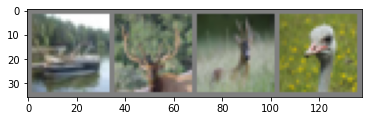

ship deer deer bird


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset has images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]

# For data augmentation
transformTrain = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformTest = transforms.Compose( # Composing several transforms together
    [transforms.ToTensor(), # To tensor object
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # mean=0.5, std=0.5

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
# load train data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformTrain)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers = num_workers)
# load test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformTest)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers = num_workers)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# visualize images
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy() #convert to numpy object
    plt.imshow(np.transpose(npimg, (1,2,0))) #####
    plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = dataiter.next()

# call function on out images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

### 3. Define the CNN 

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

network = GoogLeNet().to(device)

### 4. Define a Loss function and optimzer

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD([{'params': network.parameters()}], lr=learning_rate, weight_decay=weight_decay, momentum=momentum) 

### 5. Train the network

In [ ]:
loss_hist, acc_hist = [], []
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = network(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad() # Zero the parameter gradients
        loss.backward() # Backpropagation
        optimizer.step() # Iterates over all the parameters and update their values

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    avg_loss = running_loss / len(train_dataset)
    avg_acc = correct / len(train_dataset)
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

Epoch [1/10], Step [2000/12500], Loss: 1.4466
Epoch [1/10], Step [4000/12500], Loss: 0.9198
Epoch [1/10], Step [6000/12500], Loss: 1.6174
Epoch [1/10], Step [8000/12500], Loss: 1.7020
Epoch [1/10], Step [10000/12500], Loss: 1.8666
Epoch [1/10], Step [12000/12500], Loss: 0.5647
Epoch [2/10], Step [2000/12500], Loss: 0.5976
Epoch [2/10], Step [4000/12500], Loss: 1.5291
Epoch [2/10], Step [6000/12500], Loss: 1.1319
Epoch [2/10], Step [8000/12500], Loss: 0.6888
Epoch [2/10], Step [10000/12500], Loss: 0.3829
Epoch [2/10], Step [12000/12500], Loss: 0.3107
Epoch [3/10], Step [2000/12500], Loss: 0.5428
Epoch [3/10], Step [4000/12500], Loss: 0.2643
Epoch [3/10], Step [6000/12500], Loss: 0.3700
Epoch [3/10], Step [8000/12500], Loss: 1.0044
Epoch [3/10], Step [10000/12500], Loss: 0.7479
Epoch [3/10], Step [12000/12500], Loss: 1.3345
Epoch [4/10], Step [2000/12500], Loss: 1.2891
Epoch [4/10], Step [4000/12500], Loss: 0.2240
Epoch [4/10], Step [6000/12500], Loss: 0.0860
Epoch [4/10], Step [8000/125

In [ ]:
# Save neural network
print('Finished Training')
PATH = './cnn.pth'
torch.save(network.state_dict(), PATH)

Finished Training


### 6. Test the network on test data

In [ ]:
# Load neural network
network = GoogLeNet.to(device)
network.load_state_dict(torch.load(PATH))

AttributeError: ignored

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device) #prints 4(batchsize) labels
        outputs = network(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1) #value, index
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 86.13 %
Accuracy of airplane: 83.9 %
Accuracy of automobile: 92.7 %
Accuracy of bird: 74.1 %
Accuracy of cat: 75.1 %
Accuracy of deer: 89.7 %
Accuracy of dog: 80.3 %
Accuracy of frog: 90.1 %
Accuracy of horse: 91.0 %
Accuracy of ship: 89.9 %
Accuracy of truck: 94.5 %


### 5. Plot Training Statistics

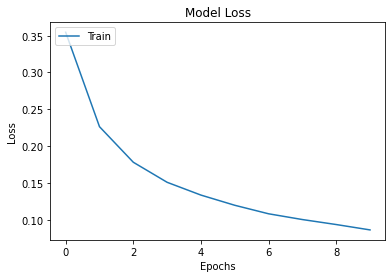

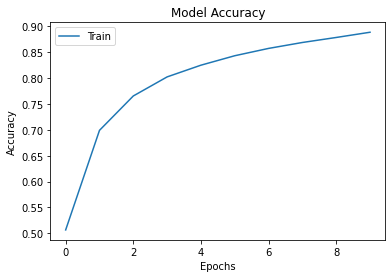

In [ ]:
import matplotlib.pyplot as plt

legend = ['Train']
plt.plot(loss_hist)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train']
plt.plot(acc_hist)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

In [ ]:
print(loss_hist)
print(acc_hist)

t2 = time.perf_counter()
print('Time taken to run:',t2-t1)

[0.3546444676682353, 0.22645737835668028, 0.17817143957795575, 0.15095361815283076, 0.13359352936002425, 0.11976557817192282, 0.10821002726848702, 0.1003891553763859, 0.09361591903806199, 0.08631286166592735]
[0.5066, 0.69904, 0.7655, 0.80236, 0.825, 0.84326, 0.85742, 0.86886, 0.87856, 0.88866]
Time taken to run: 6113.049624743


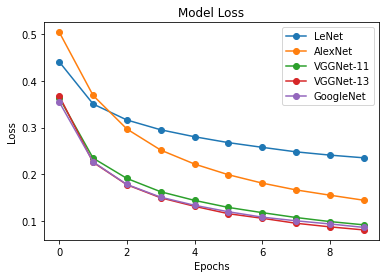

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


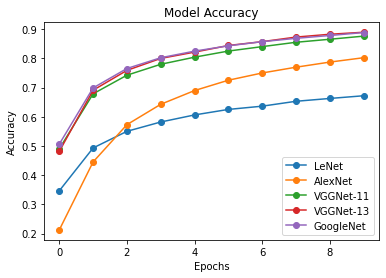

In [ ]:
a1 = [0.44082101407527924, 0.3505818564878404, 0.3163105854587257, 0.2953204952103272, 0.2804235807268694, 0.267841757921651, 0.25777765171572564, 0.24810077397678978, 0.24111905149946922, 0.23533134916414505]
a2 = [0.3466, 0.49336, 0.55034, 0.5823, 0.6065, 0.62536, 0.63648, 0.65326, 0.66292, 0.67218]
b1 = [0.5043115228319168, 0.36890032594919203, 0.29696981410795825, 0.25184293135276065, 0.22192669475345872, 0.1990432517157914, 0.18113393385502044, 0.16653655785619514, 0.15527868043990836, 0.14448904833815585]
b2 = [0.21266, 0.4455, 0.57316, 0.64296, 0.68998, 0.72538, 0.7502, 0.77, 0.78748, 0.80248]
c1 = [0.3637640256243199, 0.23463165542785078, 0.19107397313063965, 0.16256408638066613, 0.14407842268534937, 0.129047309587989, 0.1178669444969506, 0.10742129620859399, 0.0987538936956413, 0.09176285328277387]
c2 = [0.49036, 0.67884, 0.74256, 0.77998, 0.80432, 0.82524, 0.84044, 0.85534, 0.86568, 0.8764]
d1 = [0.3676798640418798, 0.22560241663990543, 0.17766396142815238, 0.14959662890581413, 0.1314362381438492, 0.11558918973972089, 0.10581700161508983, 0.09510756061355816, 0.08741097610868048, 0.08085855615851353]
d2 = [0.48158, 0.69114, 0.7591, 0.80006, 0.8216, 0.84432, 0.85748, 0.87316, 0.8828, 0.8897]
e1 = [0.3546444676682353, 0.22645737835668028, 0.17817143957795575, 0.15095361815283076, 0.13359352936002425, 0.11976557817192282, 0.10821002726848702, 0.1003891553763859, 0.09361591903806199, 0.08631286166592735]
e2 = [0.5066, 0.69904, 0.7655, 0.80236, 0.825, 0.84326, 0.85742, 0.86886, 0.87856, 0.88866]


legend = ['LeNet','AlexNet','VGGNet-11','VGGNet-13','GoogleNet']
plt.plot(a1,'o-')
plt.plot(b1,'o-')
plt.plot(c1,'o-')
plt.plot(d1,'o-')
plt.plot(e1,'o-')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

legend = ['LeNet','AlexNet','VGGNet-11','VGGNet-13','GoogleNet']
plt.plot(a2,'o-')
plt.plot(b2,'o-')
plt.plot(c2,'o-')
plt.plot(d2,'o-')
plt.plot(e2,'o-')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='bottom right')
plt.show()